# Simple MC tests to explore efficiency issues. 

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
import uproot4
from lmfit import minimize, Parameters, fit_report
from scipy import integrate

# Jupyter Lab imports.
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed

# Path to local imports.
sys.path.append("/home/drew/He6CRES/rocks_analysis_pipeline/")
from results import ExperimentResults
from rocks_utility import he6cres_db_query

# Path to local imports.
sys.path.append("/home/drew/He6CRES/he6-cres-spec-sims/")

# Local imports.
import he6_cres_spec_sims.spec_tools.spec_calc.spec_calc as sc
import he6_cres_spec_sims.experiment as exp
import he6_cres_spec_sims.spec_tools.beta_source.beta_spectrum as bs

# Local imports for plotting ratios and such. 
import analysis_functions.ratio_experiment as re
import analysis_functions.ratio_prediction as rp
import analysis_functions.plotting_methods as pm

# Plot font size
plt.rcParams.update({'font.size': 20})

## Fitting simple simulation to littleb.

* Key here is that I can't just have the perfect numbers. I need to add some uncertainty to the values in a way according to the number of counts. 
* From this you can get the C/root(N) rule for 

In [3]:
# Select set fields. 
set_fields = np.arange(1.25,3.5,.25)

# Freq BW.
freq_BW = np.array([17.9e9 ,  19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

C_exp = np.random.uniform(.25,.7)
print(C_exp)

# Simulate real data.
b = 0
ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = b, plot = False)

ratio_pred["Ratio"] 
# display(ratio_pred)

# Simulate data that provides the "spectra" df for both ne and he. You got this. 
# This way you can test out how everything works from the beginning. 

counts_per_isotope = 10**4
monitor_rate = 10**5

spectra_ne_exp = pd.DataFrame()
spectra_he_exp = pd.DataFrame()

spectra_ne_exp["set_field"] = ratio_pred.index
spectra_he_exp["set_field"] = ratio_pred.index

spectra_ne_exp.index = ratio_pred.index
spectra_he_exp.index = ratio_pred.index

spectra_ne_exp["event_count"] = ratio_pred["Ne19"]*counts_per_isotope/ratio_pred["Ne19"].sum()
spectra_he_exp["event_count"] = ratio_pred["He6"]*counts_per_isotope/ratio_pred["He6"].sum()

spectra_ne_exp["tot_monitor_rate"] = C_exp*monitor_rate
spectra_he_exp["tot_monitor_rate"] = monitor_rate

# Apply a poisson statistic with the given mean.  
spectra_ne_exp["event_count"] = np.random.poisson(spectra_ne_exp["event_count"])
spectra_he_exp["event_count"] = np.random.poisson(spectra_he_exp["event_count"])

display(spectra_ne_exp)
display(spectra_he_exp)

ratio_exp = re.build_ratio_altnorm(spectra_ne_exp, spectra_he_exp)

display(ratio_exp)

0.3598383544413253


,set_field,event_count,tot_monitor_rate
set_fields,,,
1.25,1.25,717,35983.835444
1.50,1.50,1168,35983.835444
1.75,1.75,1387,35983.835444
2.00,2.00,1702,35983.835444
2.25,2.25,1616,35983.835444
2.50,2.50,1460,35983.835444
2.75,2.75,1100,35983.835444
3.00,3.00,687,35983.835444
3.25,3.25,241,35983.835444


,set_field,event_count,tot_monitor_rate
set_fields,,,
1.25,1.25,345,100000
1.50,1.50,522,100000
1.75,1.75,750,100000
2.00,2.00,1023,100000
2.25,2.25,1218,100000
2.50,2.50,1430,100000
2.75,2.75,1518,100000
3.00,3.00,1610,100000
3.25,3.25,1580,100000


,Ne19,He6,Ratio,sRatio
set_field,,,,
1.25,0.019926,0.00345,5.775540,0.378430
1.50,0.032459,0.00522,6.218203,0.327380
1.75,0.038545,0.00750,5.139345,0.232938
2.00,0.047299,0.01023,4.623560,0.182912
2.25,0.044909,0.01218,3.687114,0.139908
2.50,0.040574,0.01430,2.837327,0.105564
2.75,0.030569,0.01518,2.013787,0.079738
3.00,0.019092,0.01610,1.185833,0.054040
3.25,0.006697,0.01580,0.423889,0.029314


In [4]:
# Fit to the free normalization parameter. 
def objfunc_chisq(my_pars, freq_BWs, ratio_exp): 

    C =my_pars["C"].value
    b =my_pars["b"].value
    # print(C,b)

    ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = b, plot = False)
    # I think the lmfit does the least squares on these values for you but double check. 
    chisq_gauss = (ratio_pred["Ratio"] - C*ratio_exp["Ratio"])/ (C*ratio_exp["sRatio"])
    # print(chisq_gauss)
    return chisq_gauss

[[Variables]]
    C:  0.38900975 +/- 0.00477015 (1.23%) (init = 1)
    b:  0.10409047 +/- 0.08341996 (80.14%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(C, b) = 0.274


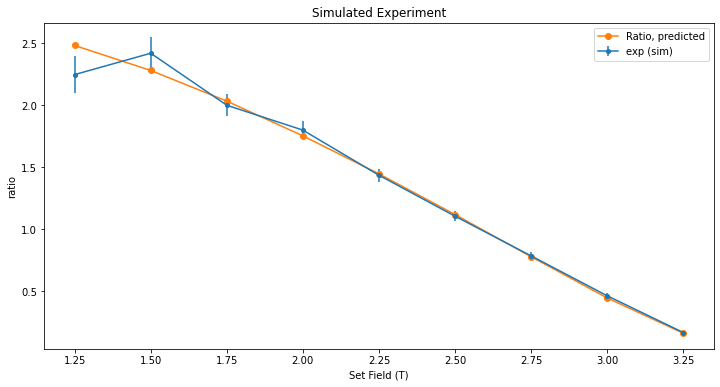

In [5]:
%matplotlib inline

import lmfit
fig0, ax0 = plt.subplots(figsize=(12,6))


my_pars = Parameters()
my_pars.add('C', value=1, min=0, max = 10, vary =True)
my_pars.add('b', value=.1, min=-10, max = 10, vary =True)

result = minimize(objfunc_chisq, my_pars, args = (freq_BWs, ratio_exp))

# mini = lmfit.Minimizer(objfunc_chisq, my_pars, fcn_args=(freq_BWs, ratio_exp))
# result = mini.minimize()


C = result.params["C"].value
# print(C)
# print(result.params)
print(fit_report(result.params))
# ci = lmfit.conf_interval(mini, result)
# print(lmfit.printfuncs.report_ci(ci))


ratio_exp_cp = ratio_exp.copy()
ratio_exp_cp["Ratio"] = C*ratio_exp_cp["Ratio"]
ratio_exp_cp["sRatio"] = C*ratio_exp_cp["sRatio"]

pm.plot_experimental_ratio(ratio_exp_cp, ax0, label= f"exp (sim)")
pm.plot_predicted_ratio(ratio_pred, ax0)

# ax0.set_yscale("log")
ax0.set_ylabel('ratio')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Simulated Experiment")
ax0.legend()
plt.show()
# print(np.array(spectrum_cuts["EventStartFreq"])/1e6)

## Systematic to consider: Wall effect.

* This should be purely math. Make it neater tomorrow. 

In [6]:


def efficiency(gamma, field, trap_radius=0.578e-2): 
    
    energy = sc.energy(gamma)
    # print(energy)
    r = sc.cyc_radius(sc.energy(gamma), field, pitch_angle = 90)
    # print(r)
    e = (trap_radius - r)**2 / trap_radius**2
    # print(field)
    return e

print(efficiency(5.07,3.75))



0.37104000374661966


In [13]:
# Select set fields. 
set_fields = np.arange(.75,3.5,.1)

# Freq BW.
freq_BW = np.array([19.0e9 ,  19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

In [14]:
def AUC_expectation(set_fields, freq_BWs, b = 0, plot = False, wall_effect = True): 
    
    integrate_vect = np.vectorize(integrate.quad)
    
    energy_acceptances_high = sc.freq_to_energy(
        freq_BWs[:,0], set_fields
    )
    energy_acceptances_low = sc.freq_to_energy(
        freq_BWs[:,1], set_fields
    )
    energy_acceptances = np.stack((energy_acceptances_low, energy_acceptances_high), axis=-1)
    
    # Empty dict to house relative rates. 
    rates = {}
    isotopes = {
    "Ne19": {
        "W0": 5.339539,
        "Z": 10,
        "A": 19,
        "beta_type": "Mixed",
        "decay_type":"+" ,
        "mixing_ratio": 2.22,
        "R": 2.9,
        "bAc": 0,
        "dAc": 0,
        "Lambda": 0,
        "b": -.7204*b
    },
    "He6": {
        "W0": 7.859525,
        "Z": 2,
        "A": 6,
        "beta_type": "Gamow-Teller",
        "decay_type":"-" ,
        "mixing_ratio": None,
        "R": 1.6,
        "bAc": 0,
        "dAc": 0,
        "Lambda": 0,
        "b": b
    }}

    # This delta_W prevents a zero argument in a log. Doesn't effect pdfs
    delta_W = 10**-10
    
    if plot: 
        pdf_plot_pts = 10**2
        f0, ax0 = plt.subplots(1, figsize=(10,5))
        f1, ax1 = plt.subplots(1, figsize=(10,5))
        f2, ax2 = plt.subplots(1, figsize=(10,5))

    for isotope_name, isotope_info in isotopes.items(): 

        W_low = sc.gamma(energy_acceptances[:, 0]) + delta_W
        W_high = sc.gamma(energy_acceptances[:, 1])-delta_W

        # Feed the info dict to the BetaSpectrum class. 
        bspec = bs.BetaSpectrum(isotope_info)
        
        if wall_effect: 
            
            def dNdE_wall_effect(gamma, field): 
                return bspec.dNdE(gamma)*efficiency(gamma, field)

            fraction_of_spectrum, err = integrate_vect(
                    dNdE_wall_effect,
                    W_low,
                    W_high,
                    args = (set_fields)
                )
        else: 
        
            fraction_of_spectrum, err = integrate_vect(
                    bspec.dNdE,
                    W_low,
                    W_high,
                )
        rates[isotope_name] = fraction_of_spectrum
        
        if plot:
            Ws = np.linspace(W_low, W_high, pdf_plot_pts)
            pdf = bspec.dNdE(Ws)
            ax0.plot(Ws, pdf)
            
            r = sc.cyc_radius(sc.energy(Ws), set_fields, pitch_angle = 90)
            ax1.plot(Ws, r)
            
            eff = efficiency(Ws, set_fields)
            ax2.plot(Ws, eff)

    if plot: 
        ax0.set_xlabel(r"$\gamma$")
        ax0.set_title("He6 and Ne19 Spectra (pdf)")
        ax1.set_xlabel(r"$\gamma$")
        ax1.set_title("radius (m)")
        ax2.set_xlabel(r"$\gamma$")
        ax2.set_title("wall effect (efficiency)")
    plt.show()


    for isotope in rates: 
        rates[isotope] = np.array(rates[isotope]) 

    rates["set_fields"] = set_fields
    rates = pd.DataFrame(rates)
    
    # Make the ratio a column of the df
    rates["Ratio"] = rates["Ne19"] / rates["He6"]
    
    rates.set_index("set_fields", inplace = True)
    return rates

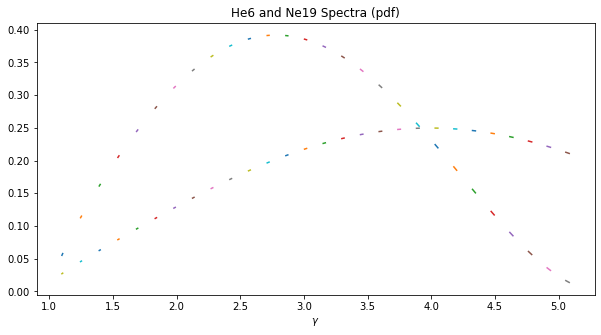

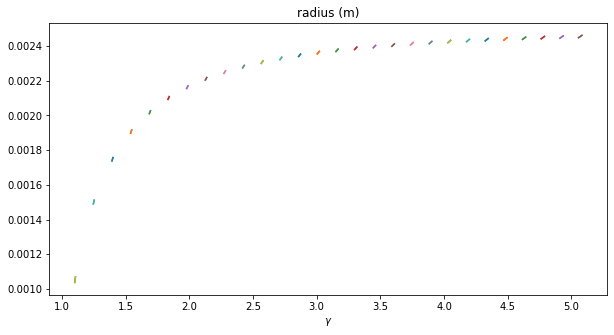

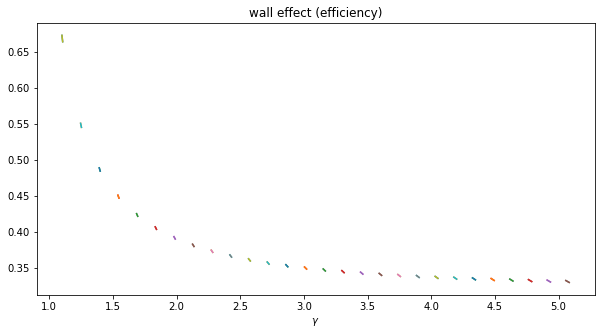

set_fields
0.75   -1.832414e-05
0.85   -2.869480e-06
0.95   -6.496331e-07
1.05    2.116583e-07
1.15    7.257089e-07
1.25    1.120978e-06
1.35    1.475734e-06
1.45    1.825278e-06
1.55    2.189753e-06
1.65    2.583531e-06
1.75    3.019108e-06
1.85    3.509119e-06
1.95    4.067690e-06
2.05    4.711653e-06
2.15    5.461908e-06
2.25    6.345206e-06
2.35    7.396647e-06
2.45    8.663393e-06
2.55    1.021041e-05
2.65    1.212968e-05
2.75    1.455575e-05
2.85    1.769309e-05
2.95    2.186758e-05
3.05    2.763106e-05
3.15    3.599546e-05
3.25    4.903318e-05
3.35    7.174570e-05
3.45    1.200185e-04
Name: Ratio, dtype: float64


Text(0.5, 1.0, '$(R_{wall} / R_0) - 1 $ ')

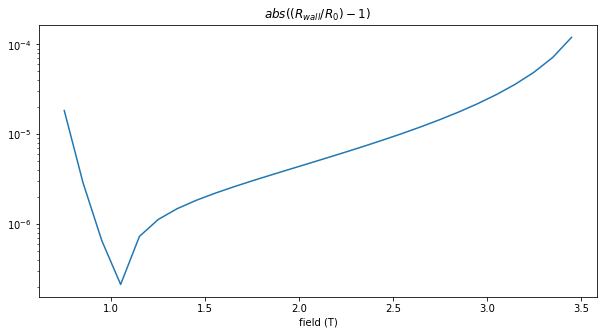

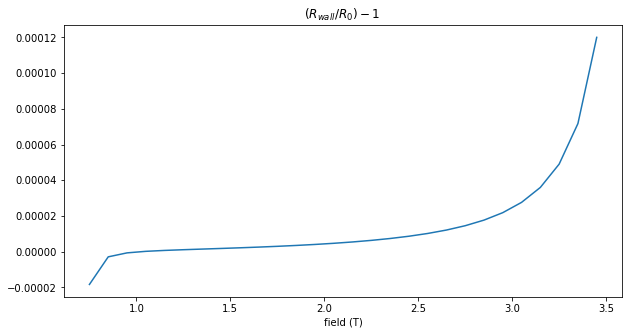

In [15]:
ratio_wall = AUC_expectation(set_fields, freq_BWs, b = 0, plot = True, wall_effect = True) 

ratio_0 = AUC_expectation(set_fields, freq_BWs, b = 0, plot = False, wall_effect = False)  

wall_effect = (ratio_wall/ratio_0 - 1)["Ratio"]

print(wall_effect)
f0, ax0 = plt.subplots(1, figsize=(10,5))
wall_effect.abs().plot(ax = ax0)

ax0.set_yscale("log")
ax0.set_xlabel(r"field (T)")
ax0.set_title(r"$abs((R_{wall} / R_0) - 1 )$ ")

f1, ax1 = plt.subplots(1, figsize=(10,5))
wall_effect.plot(ax = ax1)

ax1.set_yscale("linear")
ax1.set_xlabel(r"field (T)")
ax1.set_title(r"$(R_{wall} / R_0) - 1 $ ")

## Effect #3: Fitting .

* Going to be harder, and likely better suited to the real deal MC. 

In [6]:
my_pars = Parameters()
my_pars.add('C', value=1, min=0, max = 10, vary =False)
my_pars.add('b', value=0, min=-100, max = 100, vary =True)

result = minimize(objfunc_chisq, my_pars)

C = result.params["C"].value
print(C)
ratio_pred["Ratio"] = C*ratio_pred["Ratio"]
ratio_pred["sRatio"] = C*ratio_pred["sRatio"]

# display(ratio_pred)
base = "saved_ratio_dfs/"
path = f"exp_ratio_snr_{cut}.csv"
ratio_pred.to_csv(base + path)

# pm.plot_experimental_ratio(ratio_pred, ax0, label= f"SNR cut: {cut}")

if cut == 8: 
    path = f"pred_ratio.csv"
    ratio_pred.to_csv(base + path)
    # pm.plot_predicted_ratio(ratio_pred, ax0)

set_fields = np.arange(1.25,3.5,.25)

TypeError: objfunc_chisq() missing 2 required positional arguments: 'freq_BWs' and 'ratio_exp'

## Effect #1: Events coming up from below.

Notes: 

* bl == baseline

Issues with this study: 

* We aren't gaurenteed to see everything within this extended BW, you still need to account for the fact that something could be born in the bottom part of the extended bandwidth and not cross the "0" MHz line to be observed. What is the probability of that? This could be calculated but may be better addressed with a simple MC study. Could I incorporate this into my real MC in a simple way?? 

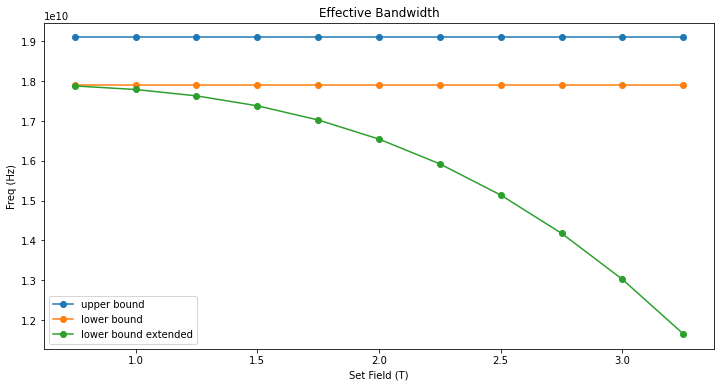

/home/drew/He6CRES/he6-cres-spec-sims/he6_cres_spec_sims/spec_tools/beta_source/beta_spectrum.py:385: RuntimeWarning: invalid value encountered in log
  * ((Wmax - W) / (3 * W) - 3 / 2 + np.log(2 * (Wmax - W)))
/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2246: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  outputs = ufunc(*inputs)
/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2246: RuntimeWarning: invalid value encountered in quad (vectorized)
  outputs = ufunc(*inputs)


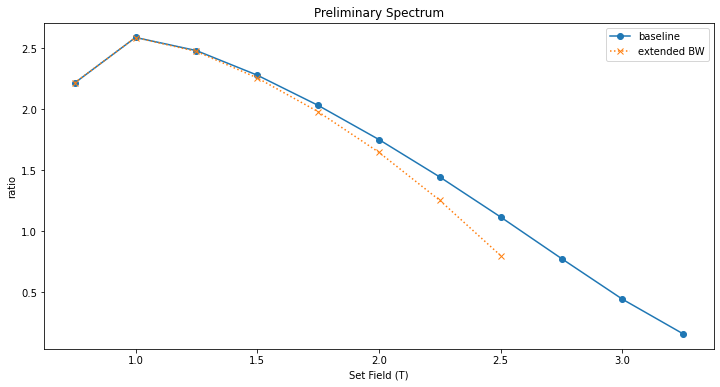

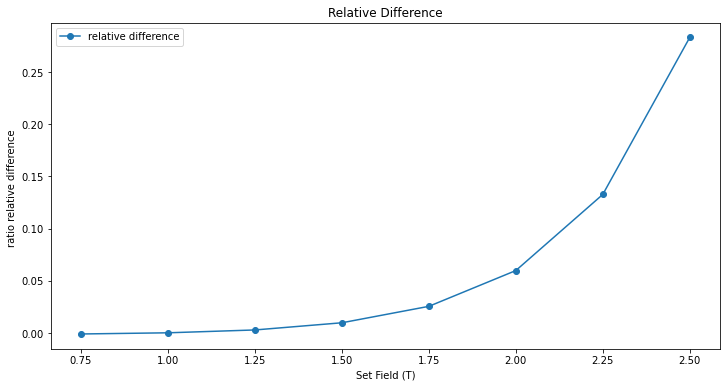

In [4]:
%matplotlib inline

# Set fields to use.
set_fields = np.arange(.75,3.5,.25)

# Freq_BW
freq_BW = np.array([17.9e9 ,  19.1e9])

# Build baseline ratio
freq_BWs_bl = np.tile(freq_BW, (len(set_fields), 1))


# Build extended BW ratio, from slope.

# Trap Slew timing. 
slew_time = 35e-3

powers = sc.power_larmor(set_fields, freq_BW.mean())
energys = sc.freq_to_energy(freq_BW.mean(), set_fields)
slopes = sc.df_dt(energys, set_fields, powers)

freq_BW_extenstion = slopes*slew_time 
freq_BWs_ext = freq_BWs_bl
freq_BWs_ext[:,0] = freq_BWs_bl[:,0] - freq_BW_extenstion

freq_BWs_bl = np.tile(freq_BW, (len(set_fields), 1))

# Plot extended BWs
fig0, ax0 = plt.subplots(figsize=(12,6))
ax0.plot(set_fields, freq_BWs_ext[:,1],  label = f"upper bound", marker='o', ms=6)
ax0.plot(set_fields, freq_BWs_bl[:,0],  label = f"lower bound", marker='o', ms=6)
ax0.plot(set_fields, freq_BWs_ext[:,0],  label = f"lower bound extended", marker='o', ms=6)
ax0.set_ylabel('Freq (Hz)')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Effective Bandwidth")
ax0.legend()
plt.show()

# Get expected ratios
ratio_bl = rp.AUC_expectation(set_fields, freq_BWs_bl, b = 0, plot = False)
ratio_ext = rp.AUC_expectation(set_fields, freq_BWs_ext, b = 0, plot = False)


# Plot ratios.
fig0, ax0 = plt.subplots(figsize=(12,6))

ax0.plot(ratio_bl.index, ratio_bl.Ratio,  label = f"baseline", marker='o', ms=6)
ax0.plot(ratio_ext.index, ratio_ext.Ratio,  label = f"extended BW", marker='x',ls = "dotted", ms=6)

ax0.set_ylabel('ratio')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Preliminary Spectrum")
ax0.legend()
plt.show()

fig0, ax0 = plt.subplots(figsize=(12,6))

ax0.plot(ratio_bl.index, (ratio_bl.Ratio - ratio_ext.Ratio) / ratio_bl.Ratio ,  label = f"relative difference", marker='o', ms=6)
# ax0.plot(ratio_ext.index, ratio_ext.Ratio,  label = f"baseline", marker='o', ms=6)

ax0.set_ylabel('ratio relative difference ')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Relative Difference")
ax0.legend()
plt.show()

## Effect #2: Frequency dependent detection efficiency.

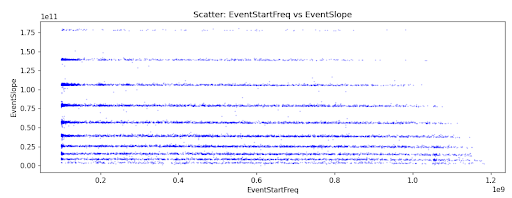

[0.0e+00 3.0e+07 6.0e+07 9.0e+07 1.2e+08 1.5e+08 1.8e+08 2.1e+08 2.4e+08
 2.7e+08 3.0e+08]


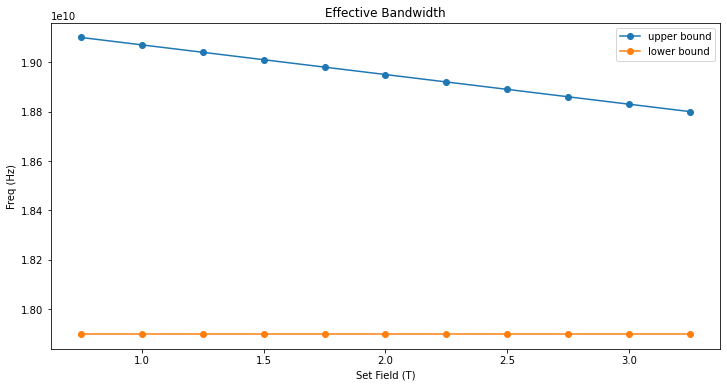

NameError: name 'freq_BWs' is not defined

In [5]:
%matplotlib inline

# Set fields to use.
set_fields = np.arange(.75,3.5,.25)

# Freq_BW
freq_BW = np.array([17.9e9 ,  19.1e9])

# Build baseline ratio
freq_BWs_bl = np.tile(freq_BW, (len(set_fields), 1))


# Build extended BW ratio, from slope.

# Trap Slew timing. 
slew_time = 35e-3

powers = sc.power_larmor(set_fields, freq_BW.mean())
energys = sc.freq_to_energy(freq_BW.mean(), set_fields)
slopes = sc.df_dt(energys, set_fields, powers)

freq_BW_reduction = np.linspace(0,300e6,len(set_fields))
print(freq_BW_reduction)
freq_BWs_ext = freq_BWs_bl
freq_BWs_ext[:,1] = freq_BWs_bl[:,1] - freq_BW_reduction


# Plot extended BWs
fig0, ax0 = plt.subplots(figsize=(12,6))
ax0.plot(set_fields, freq_BWs_ext[:,1],  label = f"upper bound", marker='o', ms=6)
ax0.plot(set_fields, freq_BWs_ext[:,0],  label = f"lower bound", marker='o', ms=6)
ax0.set_ylabel('Freq (Hz)')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Effective Bandwidth")
ax0.legend()
plt.show()

# Get expected ratios
ratio_bl = rp.AUC_expectation(set_fields, freq_BWs, b = 0, plot = False)
ratio_ext = rp.AUC_expectation(set_fields, freq_BWs_ext, b = 0, plot = False)


# Plot ratios.
fig0, ax0 = plt.subplots(figsize=(12,6))

ax0.plot(ratio_bl.index, ratio_bl.Ratio,  label = f"baseline", marker='o', ms=6)
ax0.plot(ratio_ext.index, ratio_ext.Ratio,  label = f"extended BW", marker='x',ls = "dotted", ms=6)

ax0.set_ylabel('ratio')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Preliminary Spectrum")
ax0.legend()
plt.show()

fig0, ax0 = plt.subplots(figsize=(12,6))

ax0.plot(ratio_bl.index, (ratio_bl.Ratio - ratio_ext.Ratio) / ratio_bl.Ratio ,  label = f"relative difference", marker='o', ms=6)


ax0.set_ylabel('ratio relative difference ')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Relative Difference")
ax0.legend()
plt.show()